<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/Farmaco_Sel_Preditoras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q shap # Run this if you do not have shap installed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics  import mean_squared_error
from sklearn.dummy import DummyRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer

from sklearn.tree import DecisionTreeClassifier


warnings.filterwarnings('once')

In [ ]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(col)
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.transformColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[f'{col}{self.postfix}'] = copia[f'{col}{self.postfix}']
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0], len(self.col_number_with_nan)))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)
      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

In [ ]:
def report_score(title, model, X_train, y_train, X_test, y_test) :
  model.fit(X_train, y_train)
  print(title, '\n')
  print(f'Acurácia treino: {np.round(model.score(X_train, y_train) *100, 2)}%')
  print(f'Acurácia teste: {np.round(model.score(X_test, y_test) *100, 2)}%')
  

In [ ]:
def calcula_score(model, X_train, y_train, X_test, y_test) :
  model.fit(X_train, y_train)
  return model.score(X_train, y_train), model.score(X_test, y_test)



Leitura dos Dados


In [ ]:
SEED = 48
np.random.seed(SEED)
warnings.filterwarnings(action='once')

df = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/farmaco.csv')
df.columns = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K', 'FARMACO']
preditoras = ['IDADE', 'SEXO', 'PA', 'COLESTEROL', 'NA_K']
alvo = 'FARMACO'

X = df[preditoras]
y = df[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=SEED)

print(f'Holdout: {X_train.shape[0]} individuos em treino. {X_test.shape[0]} individuos em teste.')

Holdout: 168 individuos em treino. 57 individuos em teste.


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

ordinal_transformer = Pipeline(steps=[('ordinal_encoder', OrdinalEncoder(categories=[['LOW', 'NORMAL', 'HIGH'], 
                                                                                     ['LOW', 'NORMAL', 'HIGH']], 
                                                                          handle_unknown='use_encoded_value',
                                                                          unknown_value=np.nan))
                                     ])
onehot_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])


col_transformer = ColumnTransformer(transformers=[('pa_colesterol', ordinal_transformer, ['PA', 'COLESTEROL']),
                                                  ('sex', onehot_transformer, ['SEXO'])],
                                    remainder='passthrough')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = pd.Series(le.fit_transform(y_train))


In [ ]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=10, 
                               min_samples_leaf = 2, min_samples_split = 3)

modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()),
                         ('imputer', ImputerWithMissingMark()),
                         ('classificador',  tree)]).fit(X_train, y_train_le)


transformer = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()),
                         ('imputer', ImputerWithMissingMark())]).fit(X_train)

modelo.score(X_test, le.transform(y_test))



0.9649122807017544

In [ ]:
import shap

shap.initjs() 

explainer = shap.TreeExplainer(model=modelo['classificador'])

shap_values_train = explainer.shap_values(transformer.transform(X_train), le.transform(y_train))



`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
le.inverse_transform(modelo.predict(X_train.iloc[0:1]))[0]

'MEDA'

In [ ]:
y_pred_train_proba = modelo.predict_proba(X_train)

# Vamos agora selecionar um resultado que previu como MED A
print('Probabilidade do modelo prever MED A -',100*y_pred_train_proba[0][0].round(2),'%.')
print('Probabilidade do modelo prever MED B -',100*y_pred_train_proba[0][1].round(2),'%.')

Probabilidade do modelo prever MED A - 100.0 %.
Probabilidade do modelo prever MED B - 0.0 %.


In [ ]:
shap_values_train[0][0].round(2)

array([ 0.05, -0.  ,  0.  , -0.06,  0.45,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ])

In [ ]:
shap_values_train[1][0].round(2)

array([-0.05,  0.  ,  0.  ,  0.06, -0.45,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ])

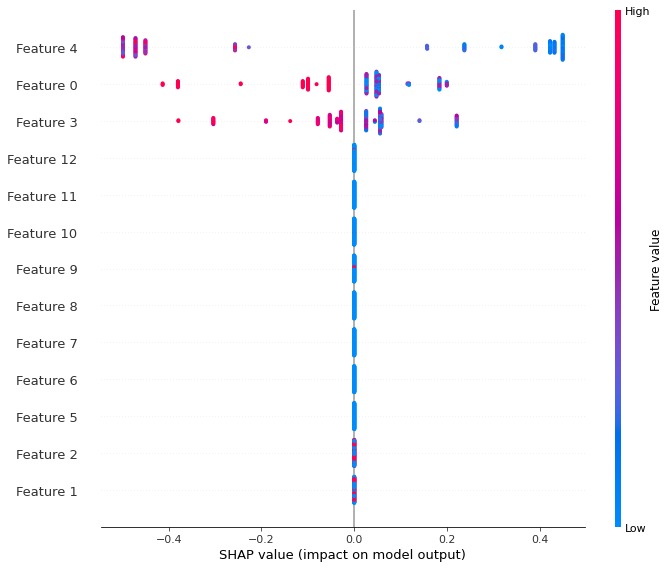

In [ ]:

shap.summary_plot(shap_values_train[1], transformer.transform(X_train), plot_type="dot", plot_size=(10,8));

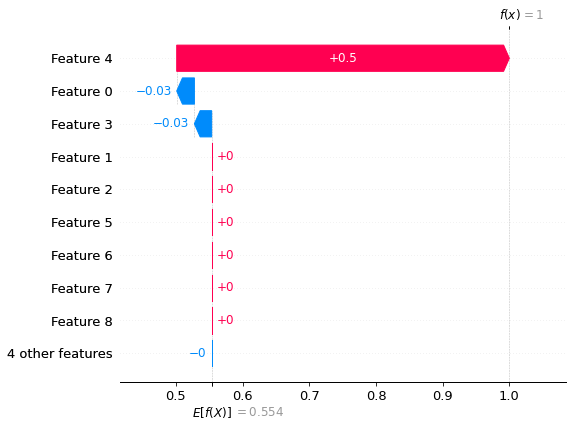

In [ ]:
shap.plots._waterfall.waterfall_legacy(expected_value=explainer.expected_value[0],
                                       shap_values=shap_values_train[0][12].reshape(-1), show=True)